In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from torchvision import datasets
from PIL import Image


In [2]:
class EuroSATDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        # List all class directories, ignore .DS_Store files and directories
        self.classes = [class_name for class_name in os.listdir(root_dir) 
                        if os.path.isdir(os.path.join(root_dir, class_name)) and class_name != ".DS_Store"]
        
        self.image_paths = []
        self.labels = []
        
        # Collect all images and labels, ignoring .DS_Store files
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.endswith(".jpg") and img_name != ".DS_Store":  # Exclude .DS_Store
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(label)
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")  # Ensure 3 channels (RGB)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label


In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to a fixed size (64x64)
    transforms.ToTensor(),        # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

In [4]:
root_dir = 'EuroSAT'  # Set the path to the EuroSAT dataset
dataset = EuroSATDataset(root_dir=root_dir, transform=transform)

# Define split sizes (e.g., 80% train, 10% validation, 10% test)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size  # Ensure the remaining data goes to test

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [5]:
CLASSES_DICT = dict(enumerate(dataset.classes))

In [6]:
class EuroSATModel(nn.Module):
    def __init__(self, num_classes=10):
        super(EuroSATModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # Assuming input size is 64x64
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        
        x = x.view(-1, 128 * 8 * 8)  # Flatten the output
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [7]:
model = EuroSATModel(num_classes=10)  # EuroSAT has 10 classes

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)


In [8]:
class EarlyStopper():
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [9]:
num_epochs = 10
early_stopper = EarlyStopper(patience=2, min_delta=0.001)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    if early_stopper.early_stop(val_loss):         
        print('Early Stopping activated')    
        break


Epoch [1/10], Train Loss: 0.6996, Val Loss: 0.3937
Epoch [2/10], Train Loss: 0.3534, Val Loss: 0.3051
Epoch [3/10], Train Loss: 0.2856, Val Loss: 0.2926
Epoch [4/10], Train Loss: 0.2356, Val Loss: 0.2095
Epoch [5/10], Train Loss: 0.1937, Val Loss: 0.1969
Epoch [6/10], Train Loss: 0.1658, Val Loss: 0.2148
Epoch [7/10], Train Loss: 0.1351, Val Loss: 0.1320
Epoch [8/10], Train Loss: 0.1052, Val Loss: 0.1289
Epoch [9/10], Train Loss: 0.0931, Val Loss: 0.1461
Epoch [10/10], Train Loss: 0.0847, Val Loss: 0.1521
Early Stopping activated


In [10]:
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

accuracy = accuracy_score(all_labels, all_predictions)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(all_labels, all_predictions))


Accuracy: 0.9323
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       241
           1       0.96      1.00      0.98       289
           4       0.91      0.94      0.92       255
           5       0.91      0.98      0.94       303
           7       0.96      0.94      0.95       195
           8       0.97      0.86      0.91       267

    accuracy                           0.93      1550
   macro avg       0.93      0.93      0.93      1550
weighted avg       0.93      0.93      0.93      1550



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


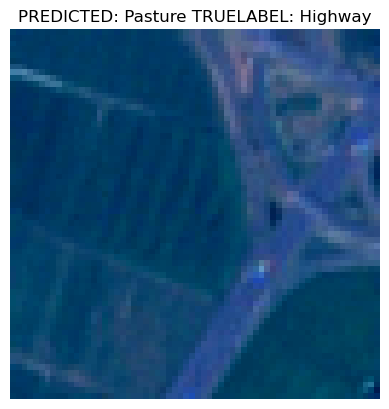

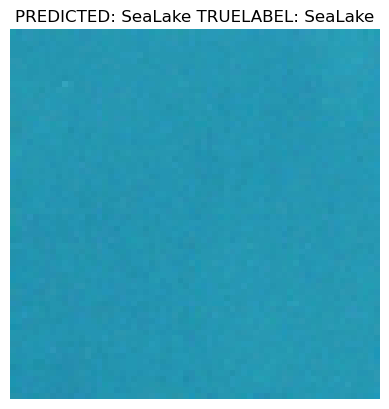

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


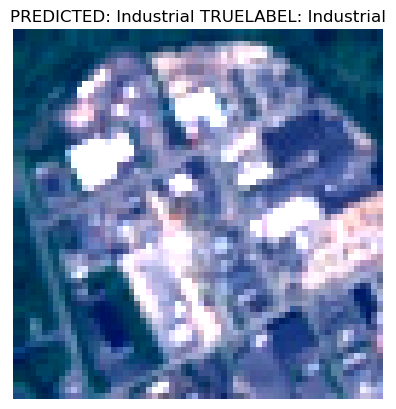

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


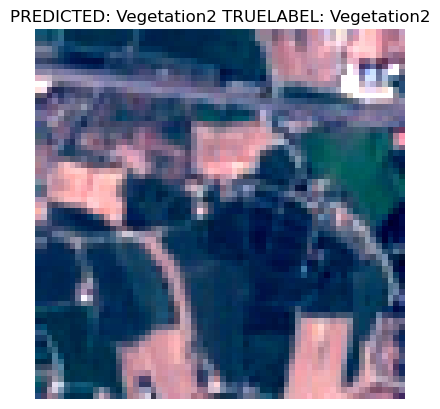

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


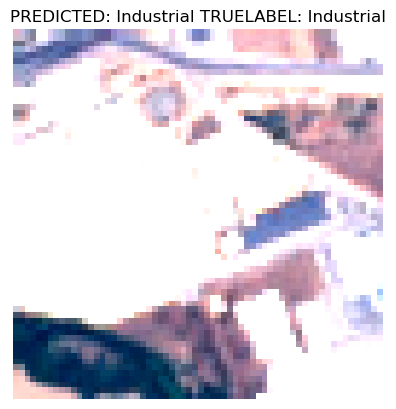

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


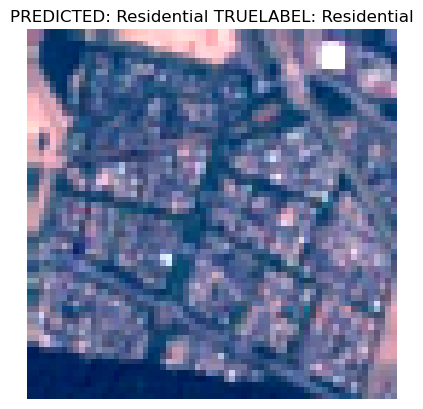

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


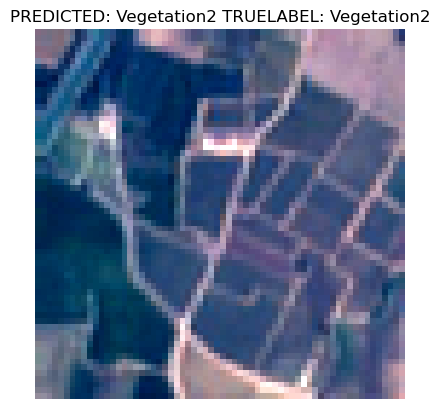

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


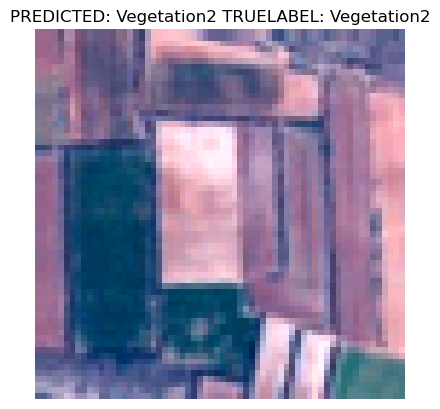

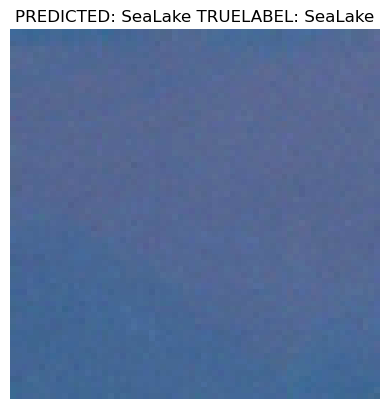

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


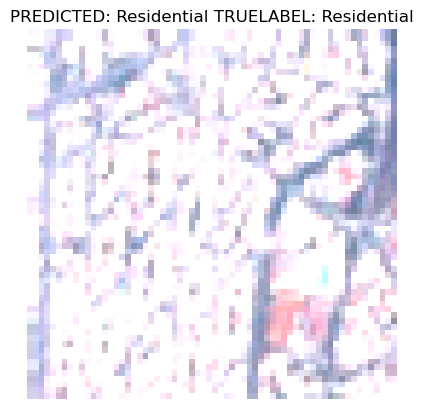

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


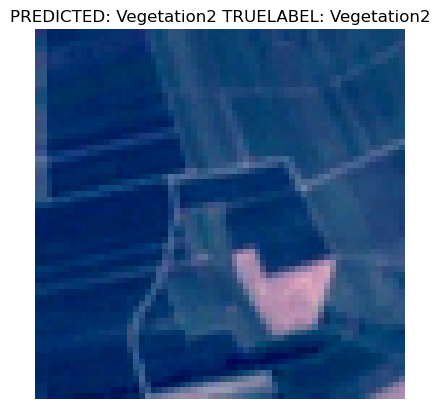

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


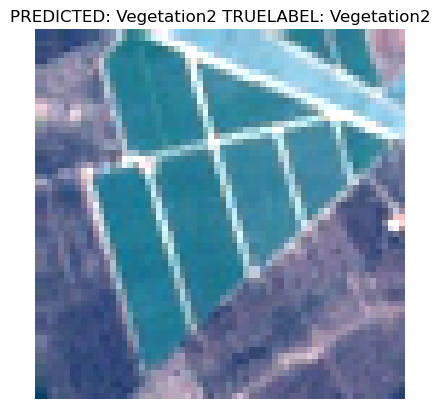

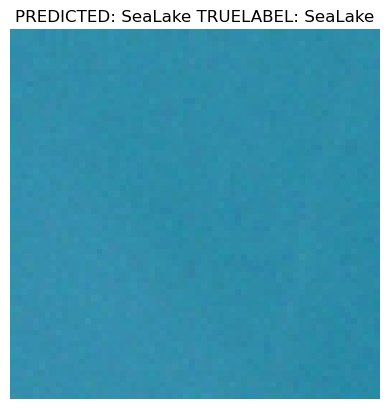

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


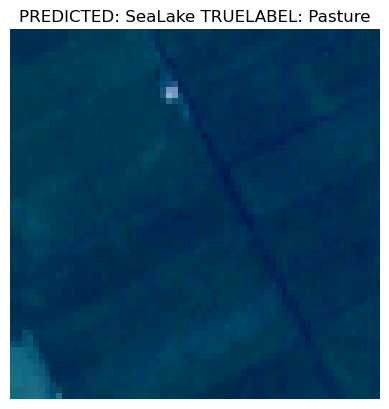

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


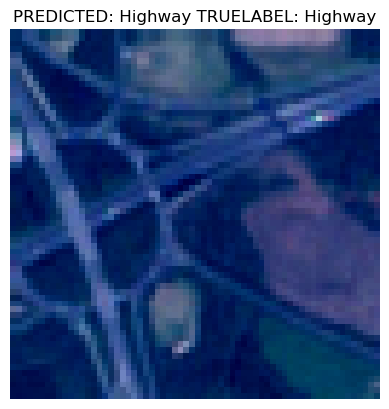

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


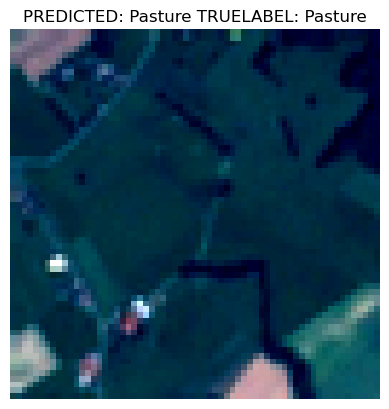

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


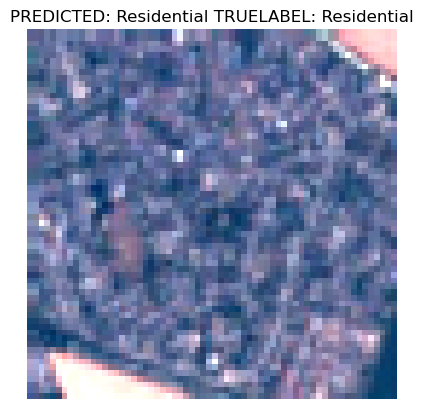

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


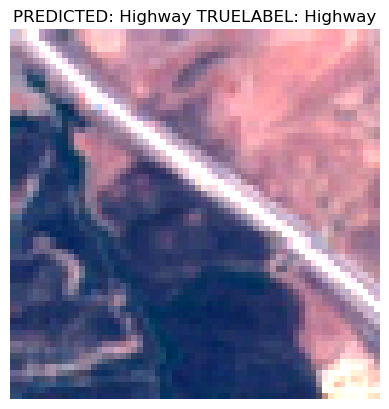

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


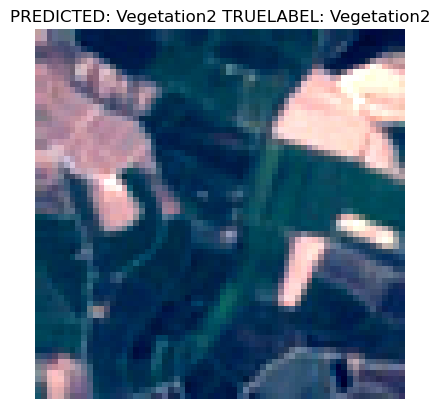

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


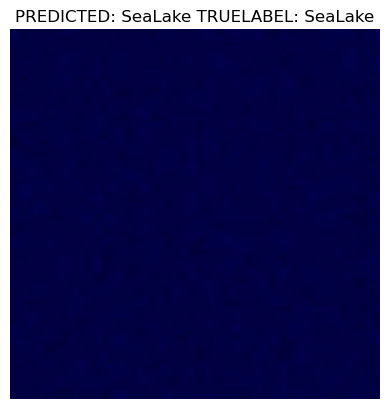

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


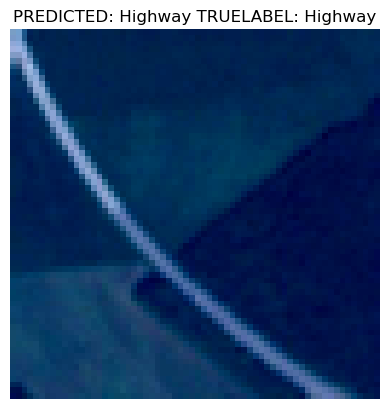

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


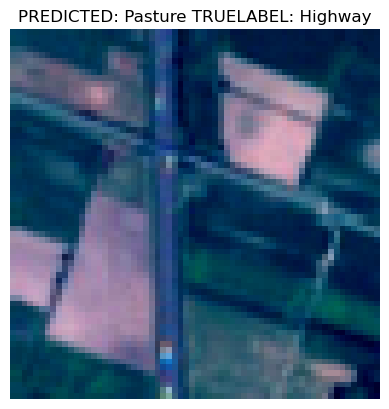

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


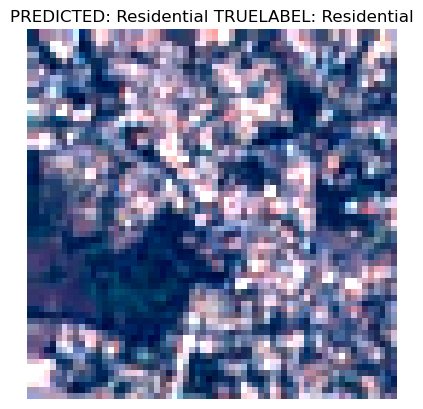

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


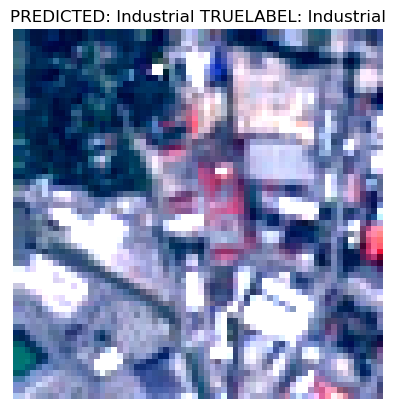

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


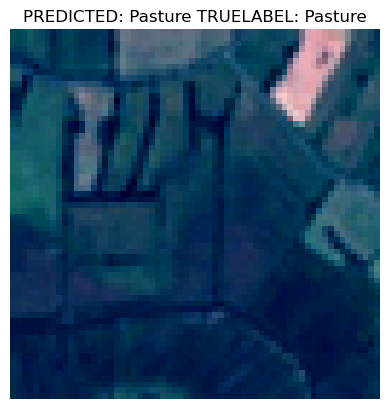

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


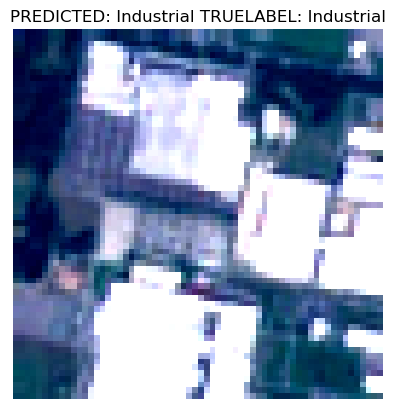

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


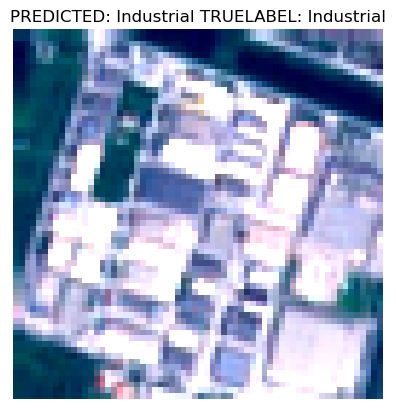

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


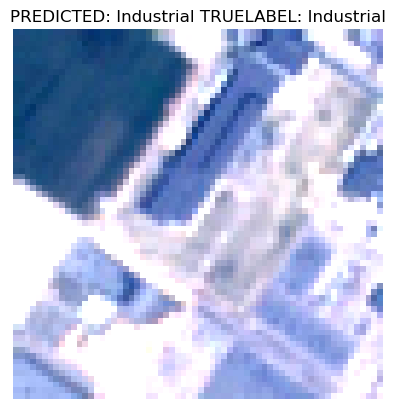

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


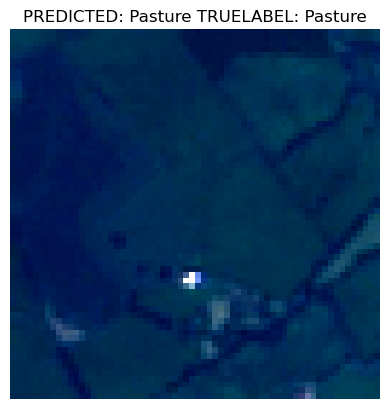

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


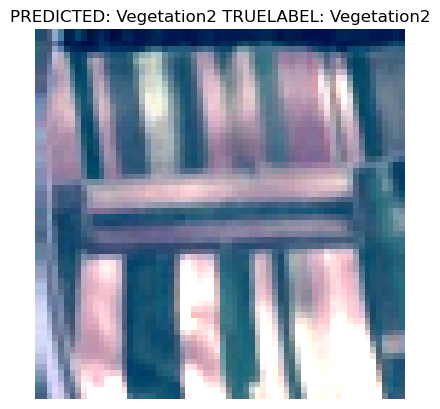

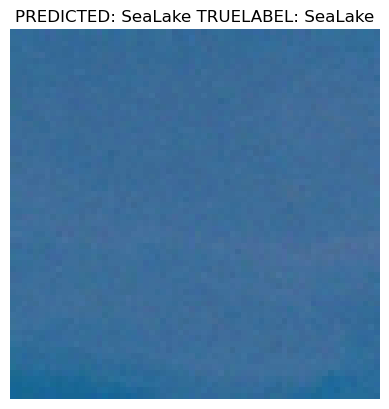

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


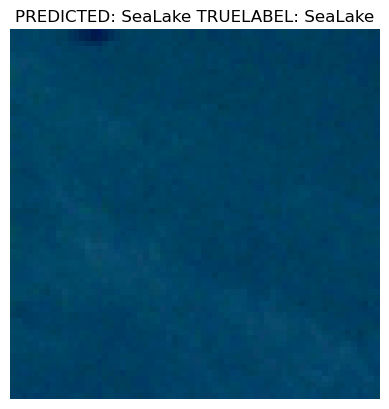

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


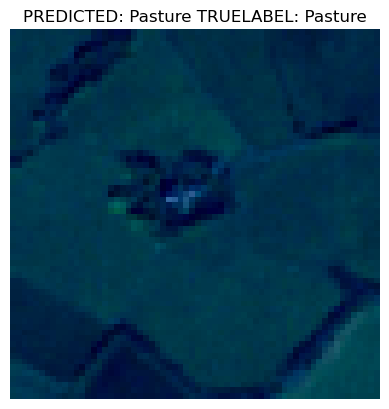

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


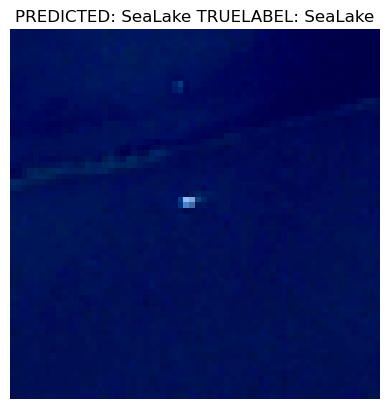

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


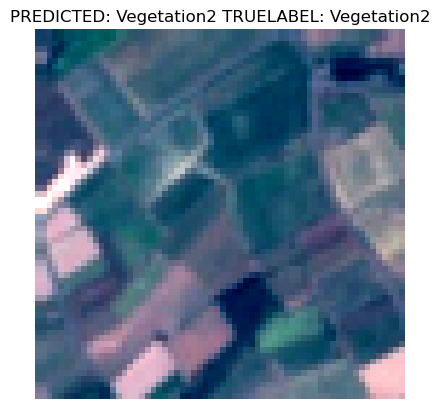

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


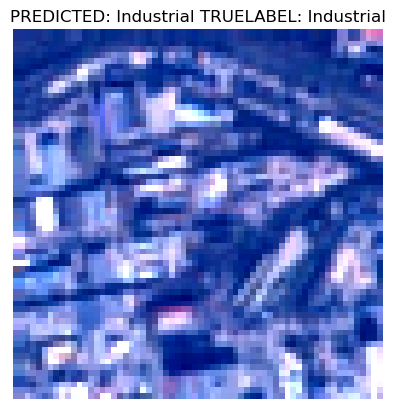

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


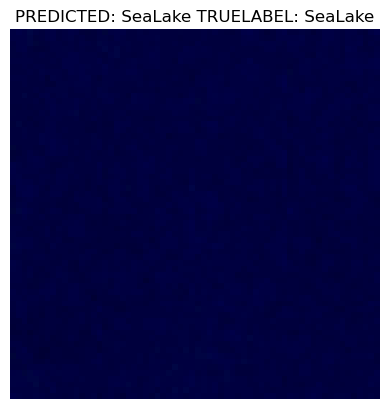

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


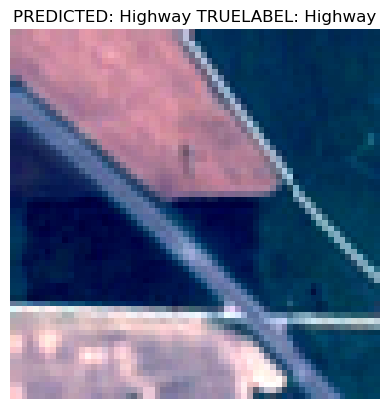

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


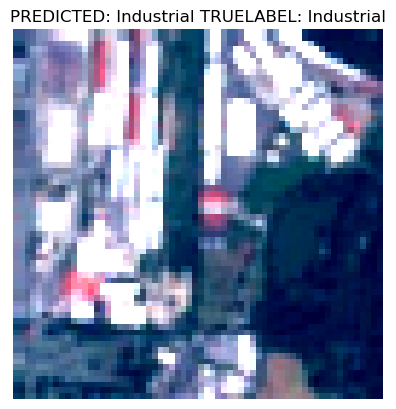

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


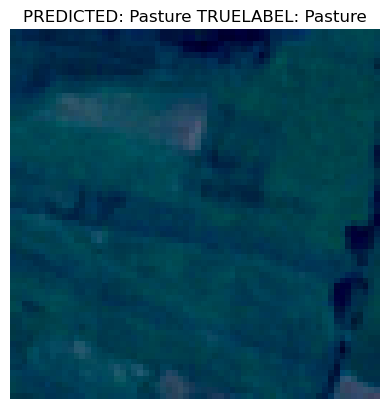

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


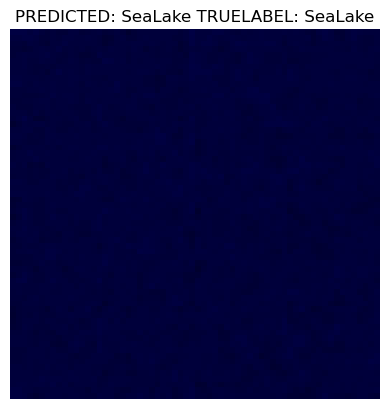

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


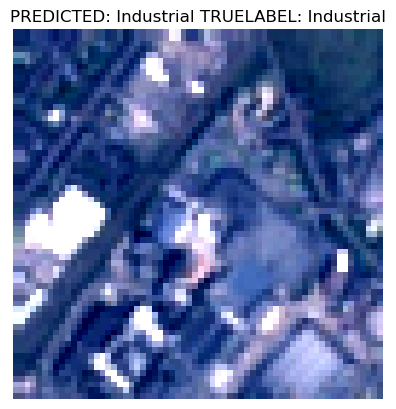

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


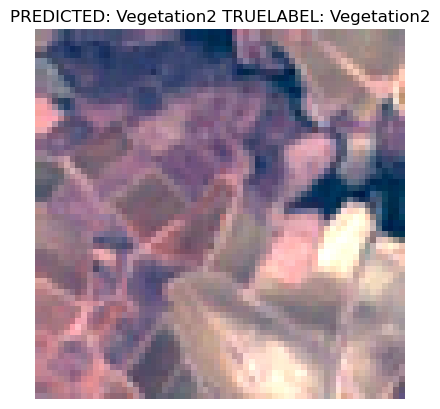

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


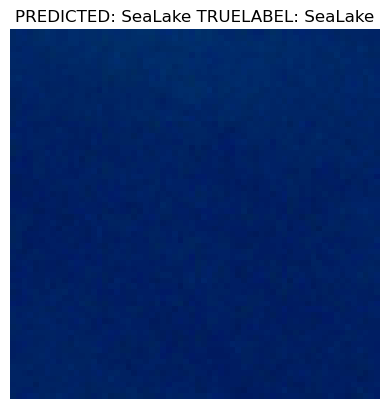

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


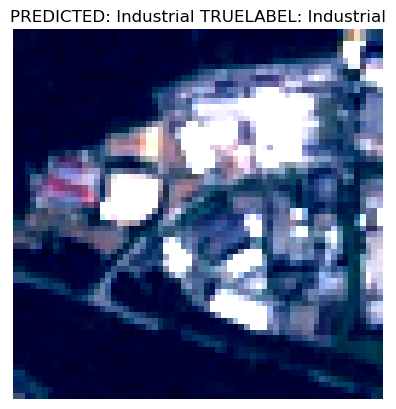

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


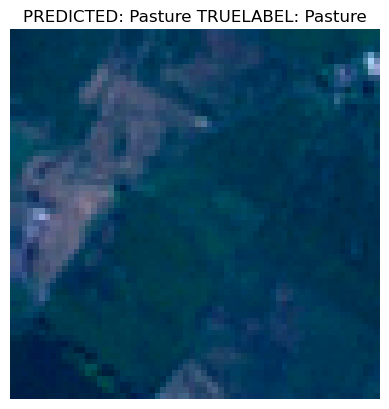

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


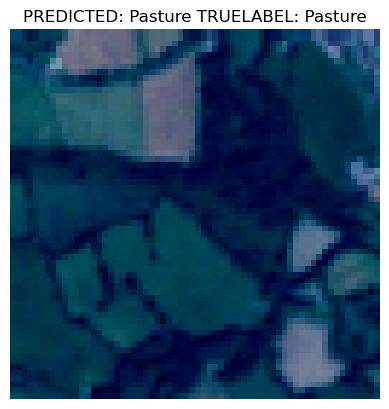

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


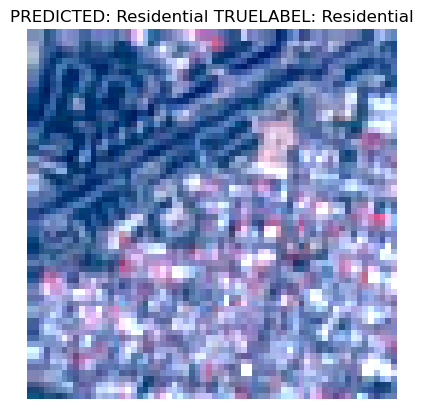

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


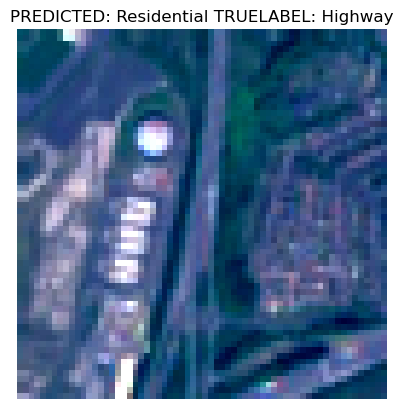

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


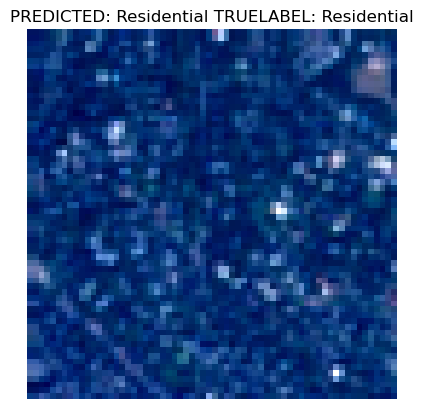

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


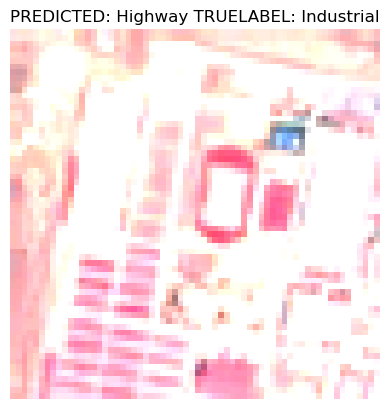

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


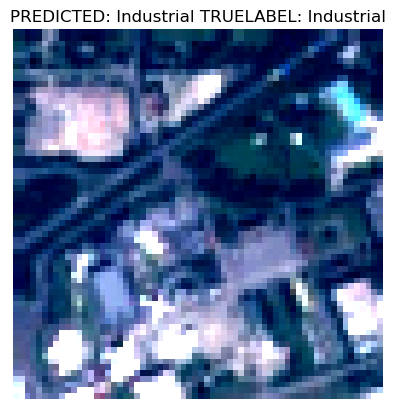

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


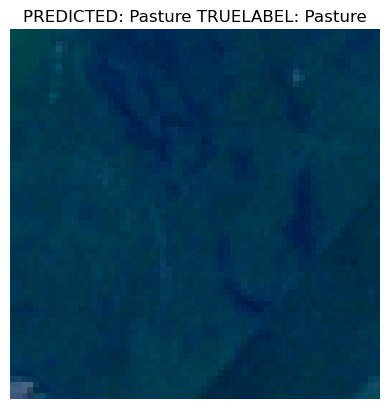

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


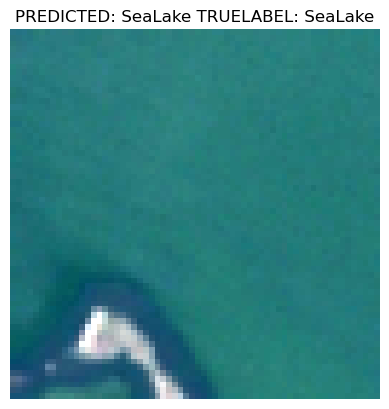

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


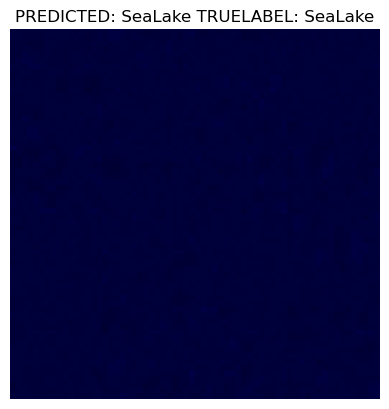

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


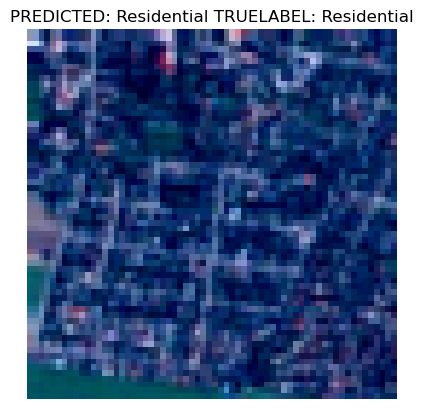

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


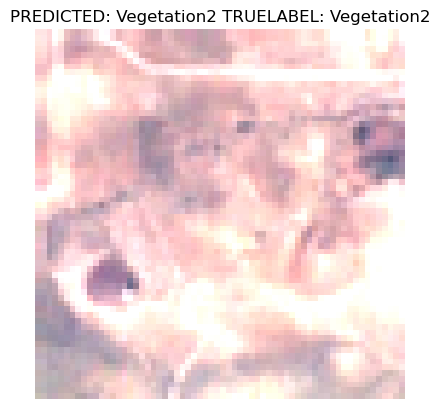

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


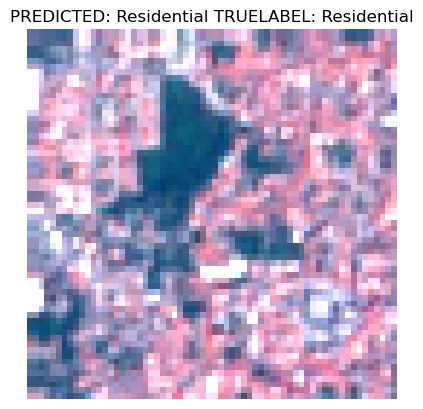

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


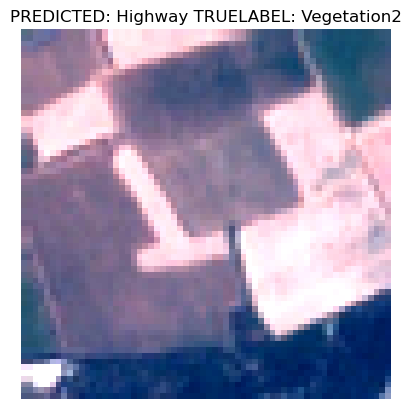

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


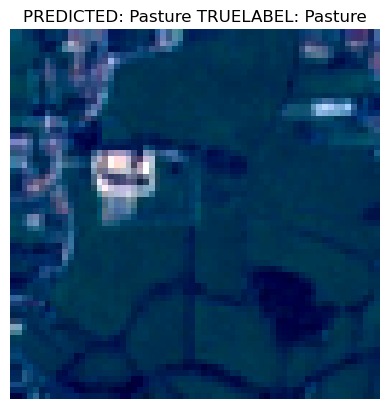

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


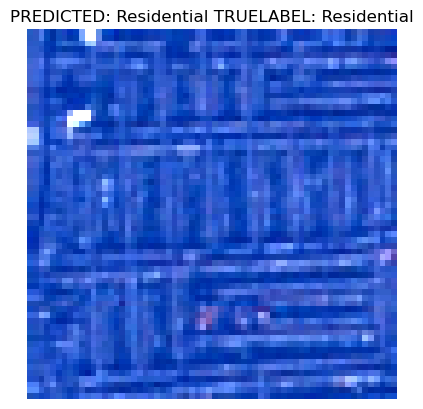

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


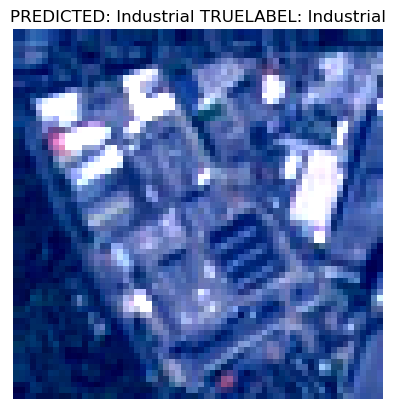

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


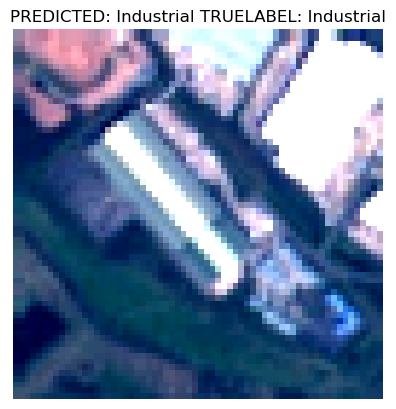

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


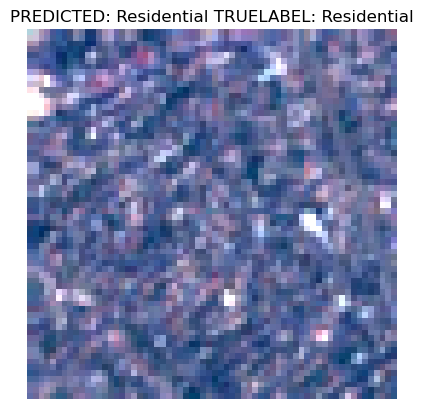

In [11]:

def imshow(img, true_label=None, pred_class=None):
    """Display a single image with its predicted class label."""
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)

    plt.imshow(npimg)
    plt.axis('off')  # Hide axes

    if true_label != None:
        plt.title(f'PREDICTED: {pred_class} TRUELABEL: {true_label}', fontsize=12, color='black')
    else:
        plt.title(f'PREDICTED: {pred_class} ', fontsize=12, color='black')

    plt.show()

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Get predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Show each image with its prediction
for img, true_labels, pred in zip(images, labels, predicted):
    imshow(img, CLASSES_DICT[true_labels.item()], CLASSES_DICT[pred.item()])  # Convert tensor to label using dictionary


In [55]:
# Open the image

img = Image.open(os.getcwd() + '/data/20230215-SE2B-CGG-GBR-MS3-L3-RGB-preview.jpg')
# img = Image.open('data/Oisin.PNG')

print(img.size)
# Image dimensions
img_width, img_height = img.size

# Define the size of the smaller image (64x64)
block_size = 64

# List to hold the sliced images
sliced_images = []

# Loop through the image and slice it
for top in range(0, img_height, block_size):
    for left in range(0, img_width, block_size):
        if (img_height - top) < block_size or (img_width - left) < block_size:
            continue

        # Define the coordinates of the box to slice the image
        box = (left, top, left + block_size, top + block_size)
        
        # Crop the image
        cropped_img = img.crop(box)
        
        # Append the cropped image to the list
        sliced_images.append(cropped_img)

        # print(box)

# Print number of slices
print(f"Total number of 64x64 slices: {len(sliced_images)}")

# You can now use `sliced_images` for further processing


(500, 500)
Total number of 64x64 slices: 49


In [56]:
# Define the transformation to convert PIL images to tensors
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 64x64
    transforms.ToTensor(),        # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Convert each image in the list to a tensor
image_tensors = [transform(img) for img in sliced_images]

# Stack the list of image tensors into a single batch (4D tensor)
image_batch = torch.stack(image_tensors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


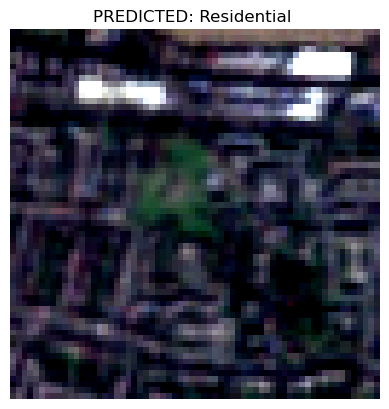

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


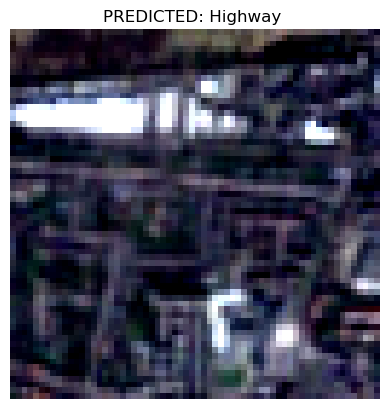

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


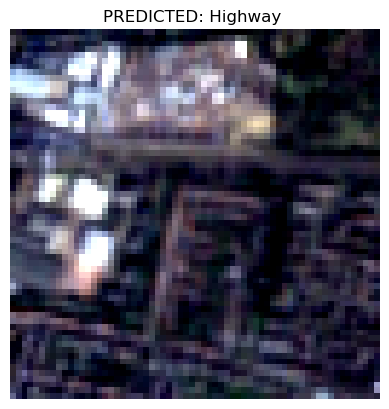

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


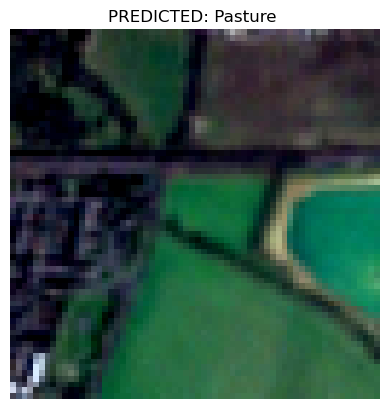

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


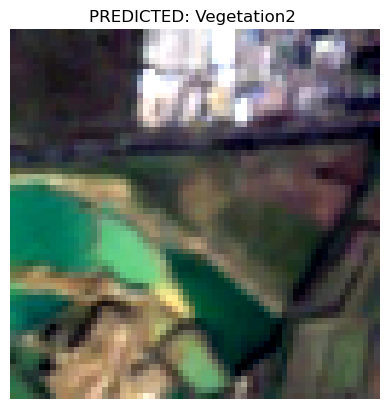

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


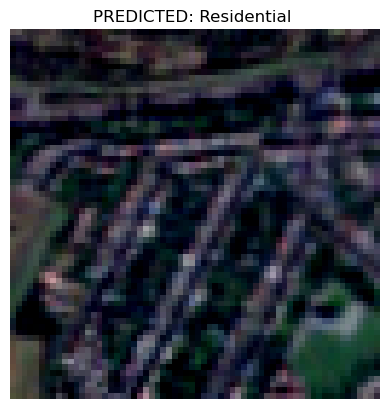

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


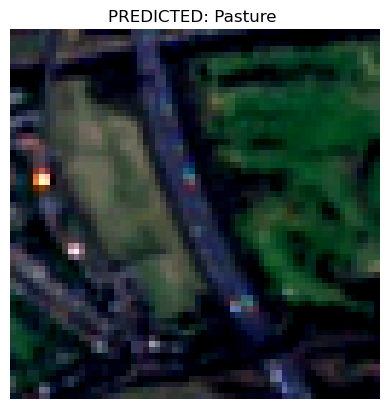

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


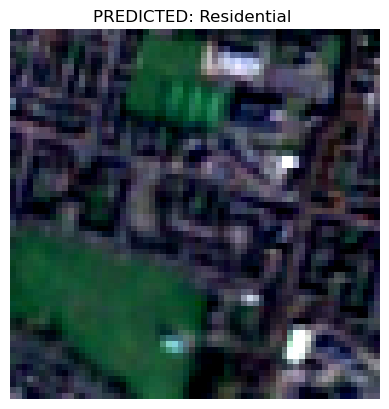

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


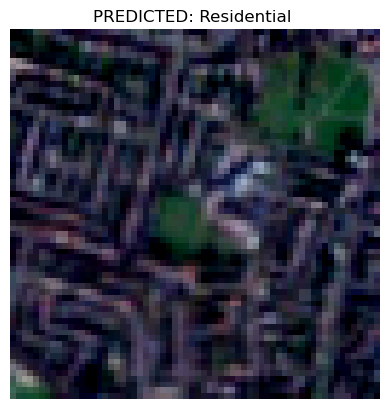

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


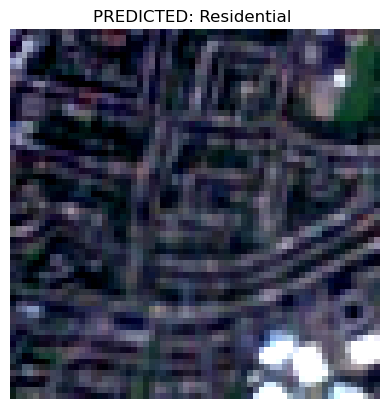

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


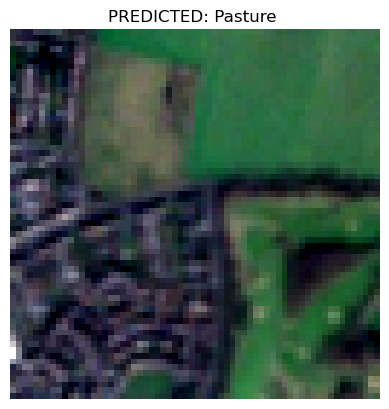

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


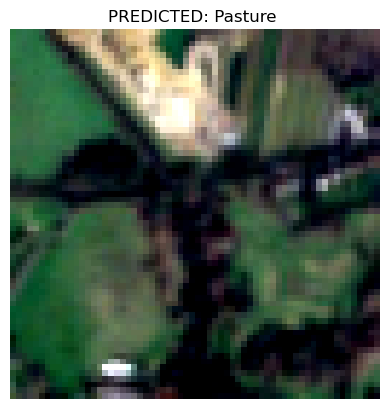

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


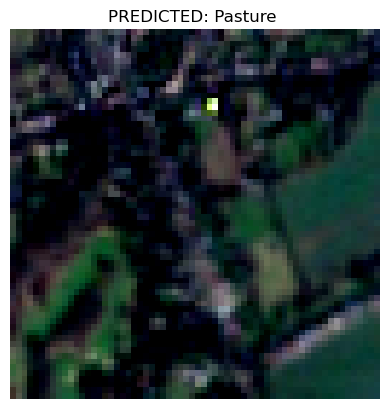

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


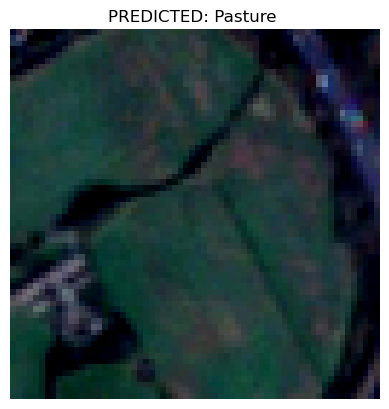

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


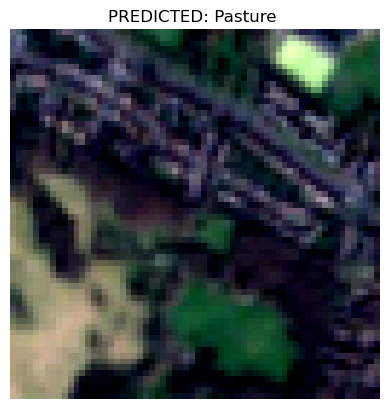

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


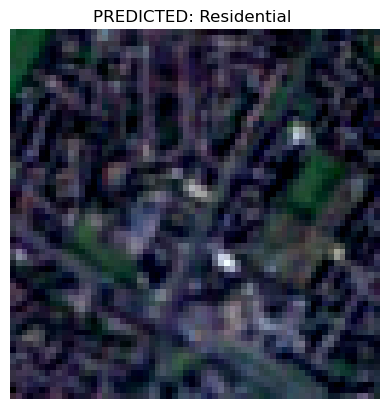

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


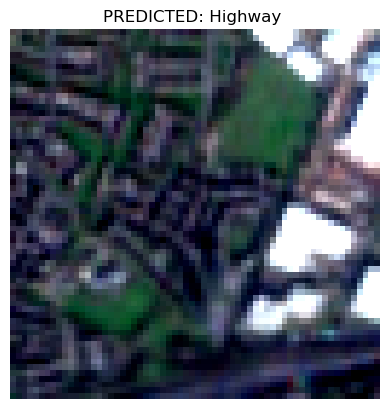

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


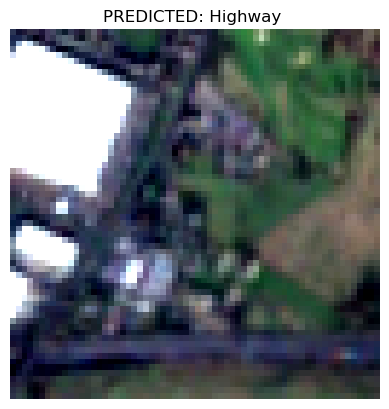

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


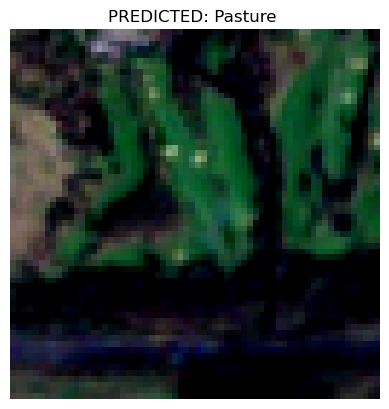

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


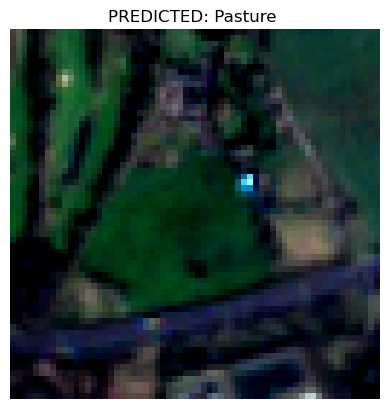

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


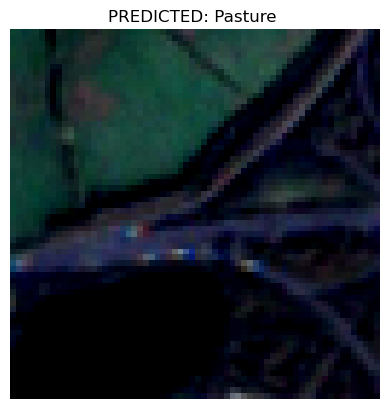

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


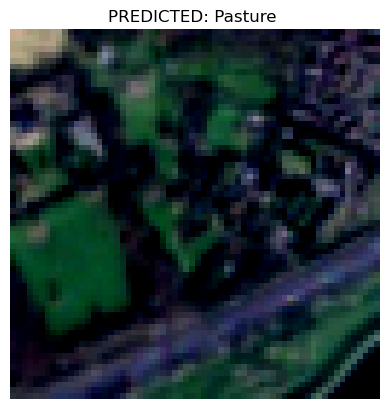

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


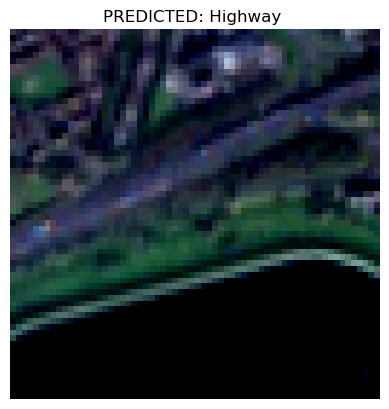

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


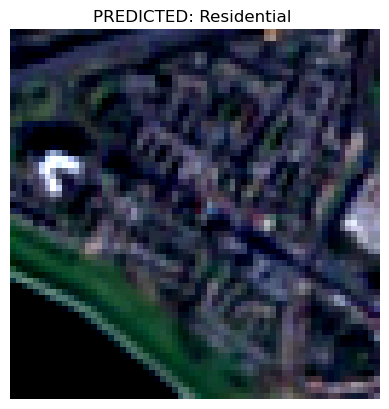

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


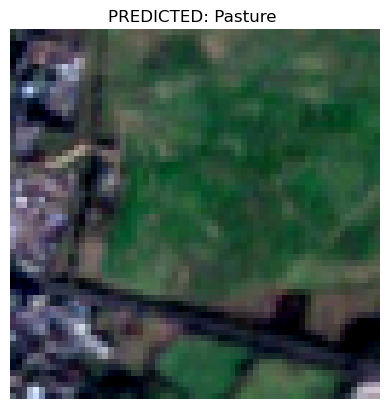

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


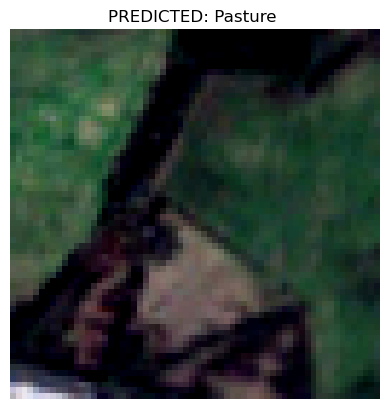

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


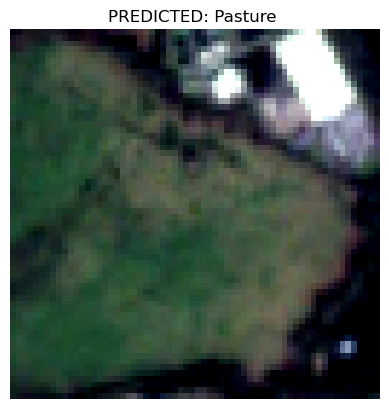

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


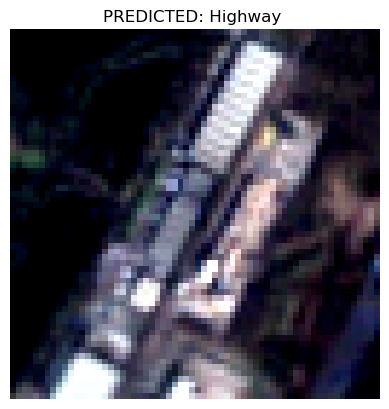

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


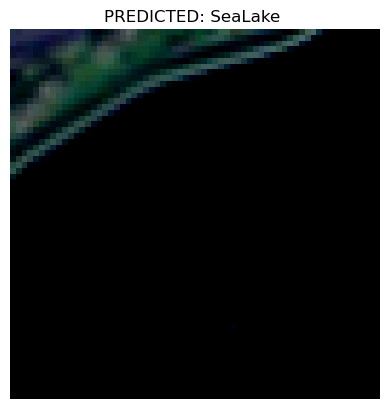

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


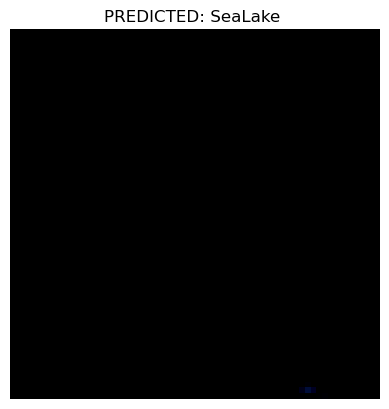

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


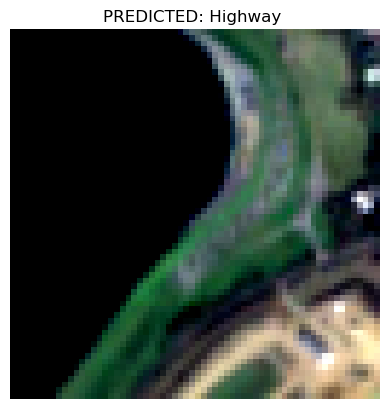

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


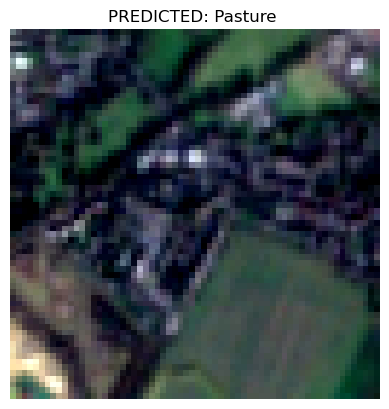

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


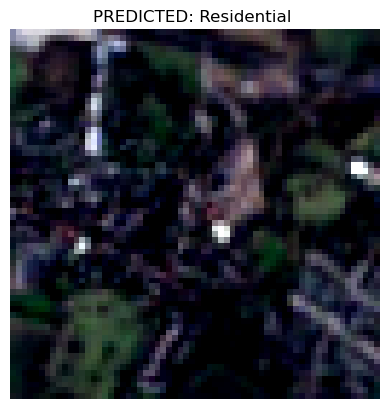

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


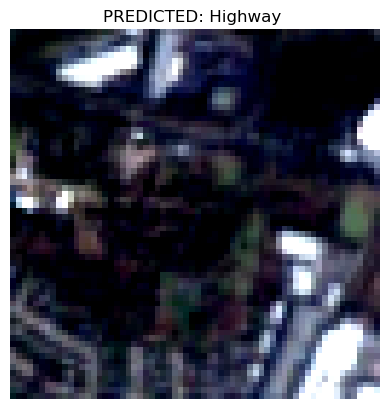

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


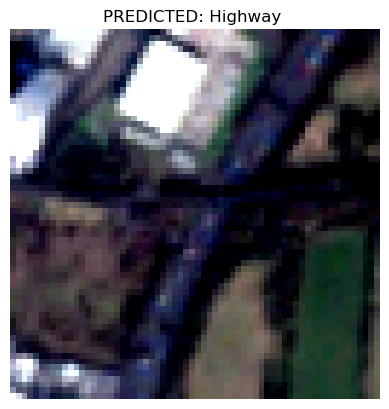

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


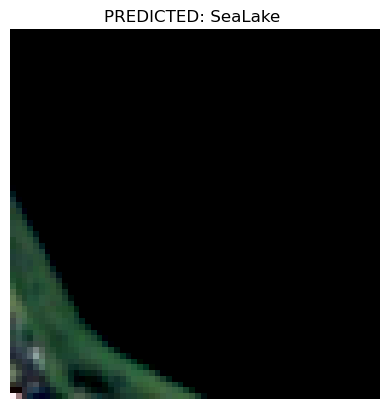

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


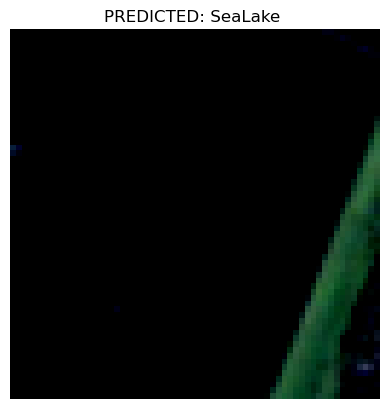

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


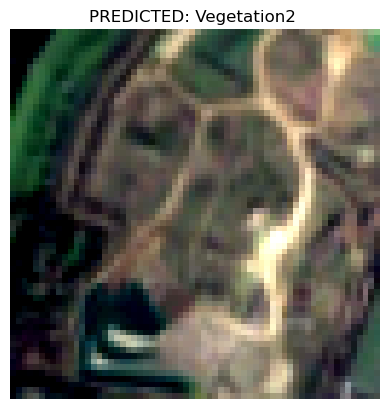

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


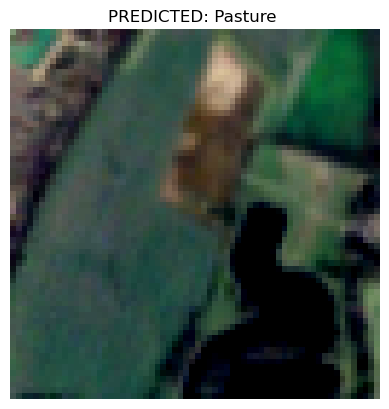

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


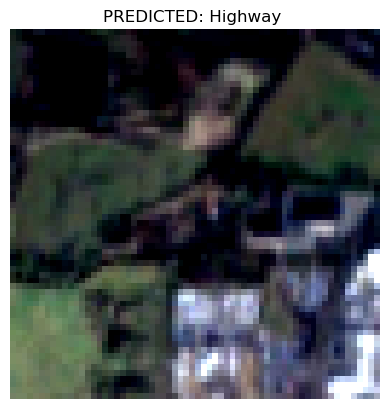

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


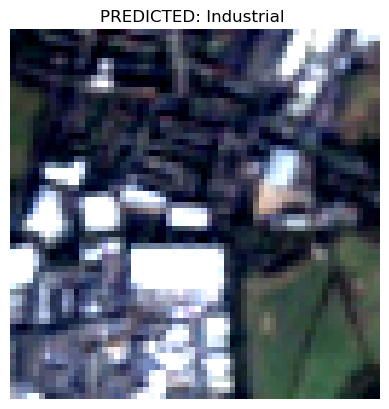

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


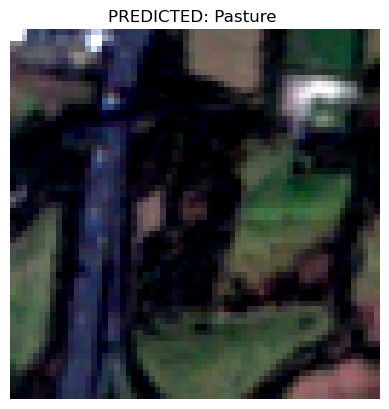

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


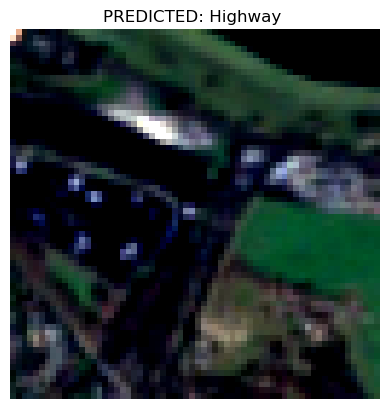

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


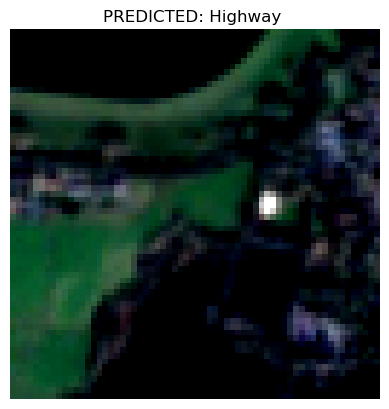

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


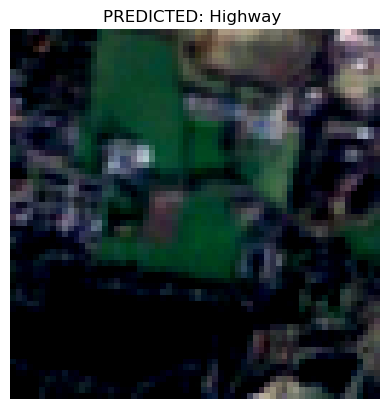

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


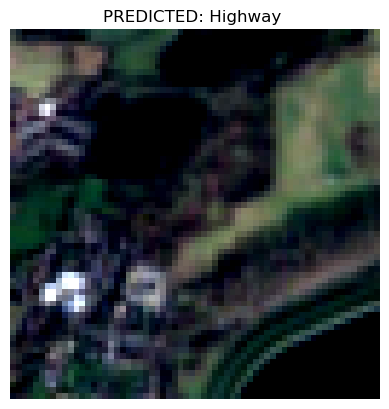

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


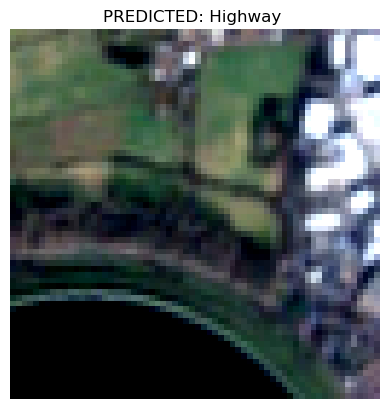

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


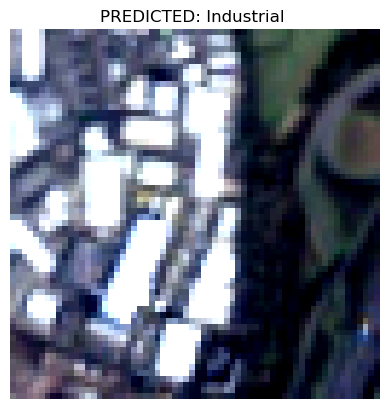

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


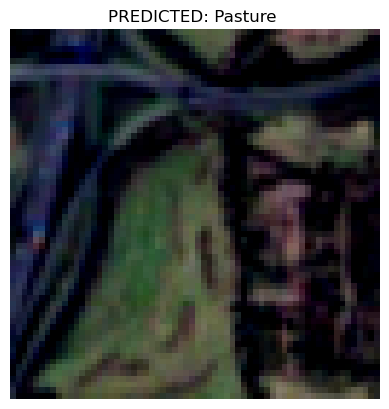

In [57]:
# Get predictions
sliced_outputs = model(image_batch)
_, sliced_predicted = torch.max(sliced_outputs, 1)
image_predict_zip = list(zip(image_batch, sliced_predicted))

# Show each image with its prediction
for img, pred in image_predict_zip:
    imshow(img, None, CLASSES_DICT[pred.item()])  # Convert tensor to label using dictionary


In [58]:
for u in np.unique(predicted_classes):
    print(u, CLASSES_DICT[u])

0 Highway
1 SeaLake
4 Industrial
5 Residential
7 Pasture
8 Vegetation2


## Land Use Classification

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

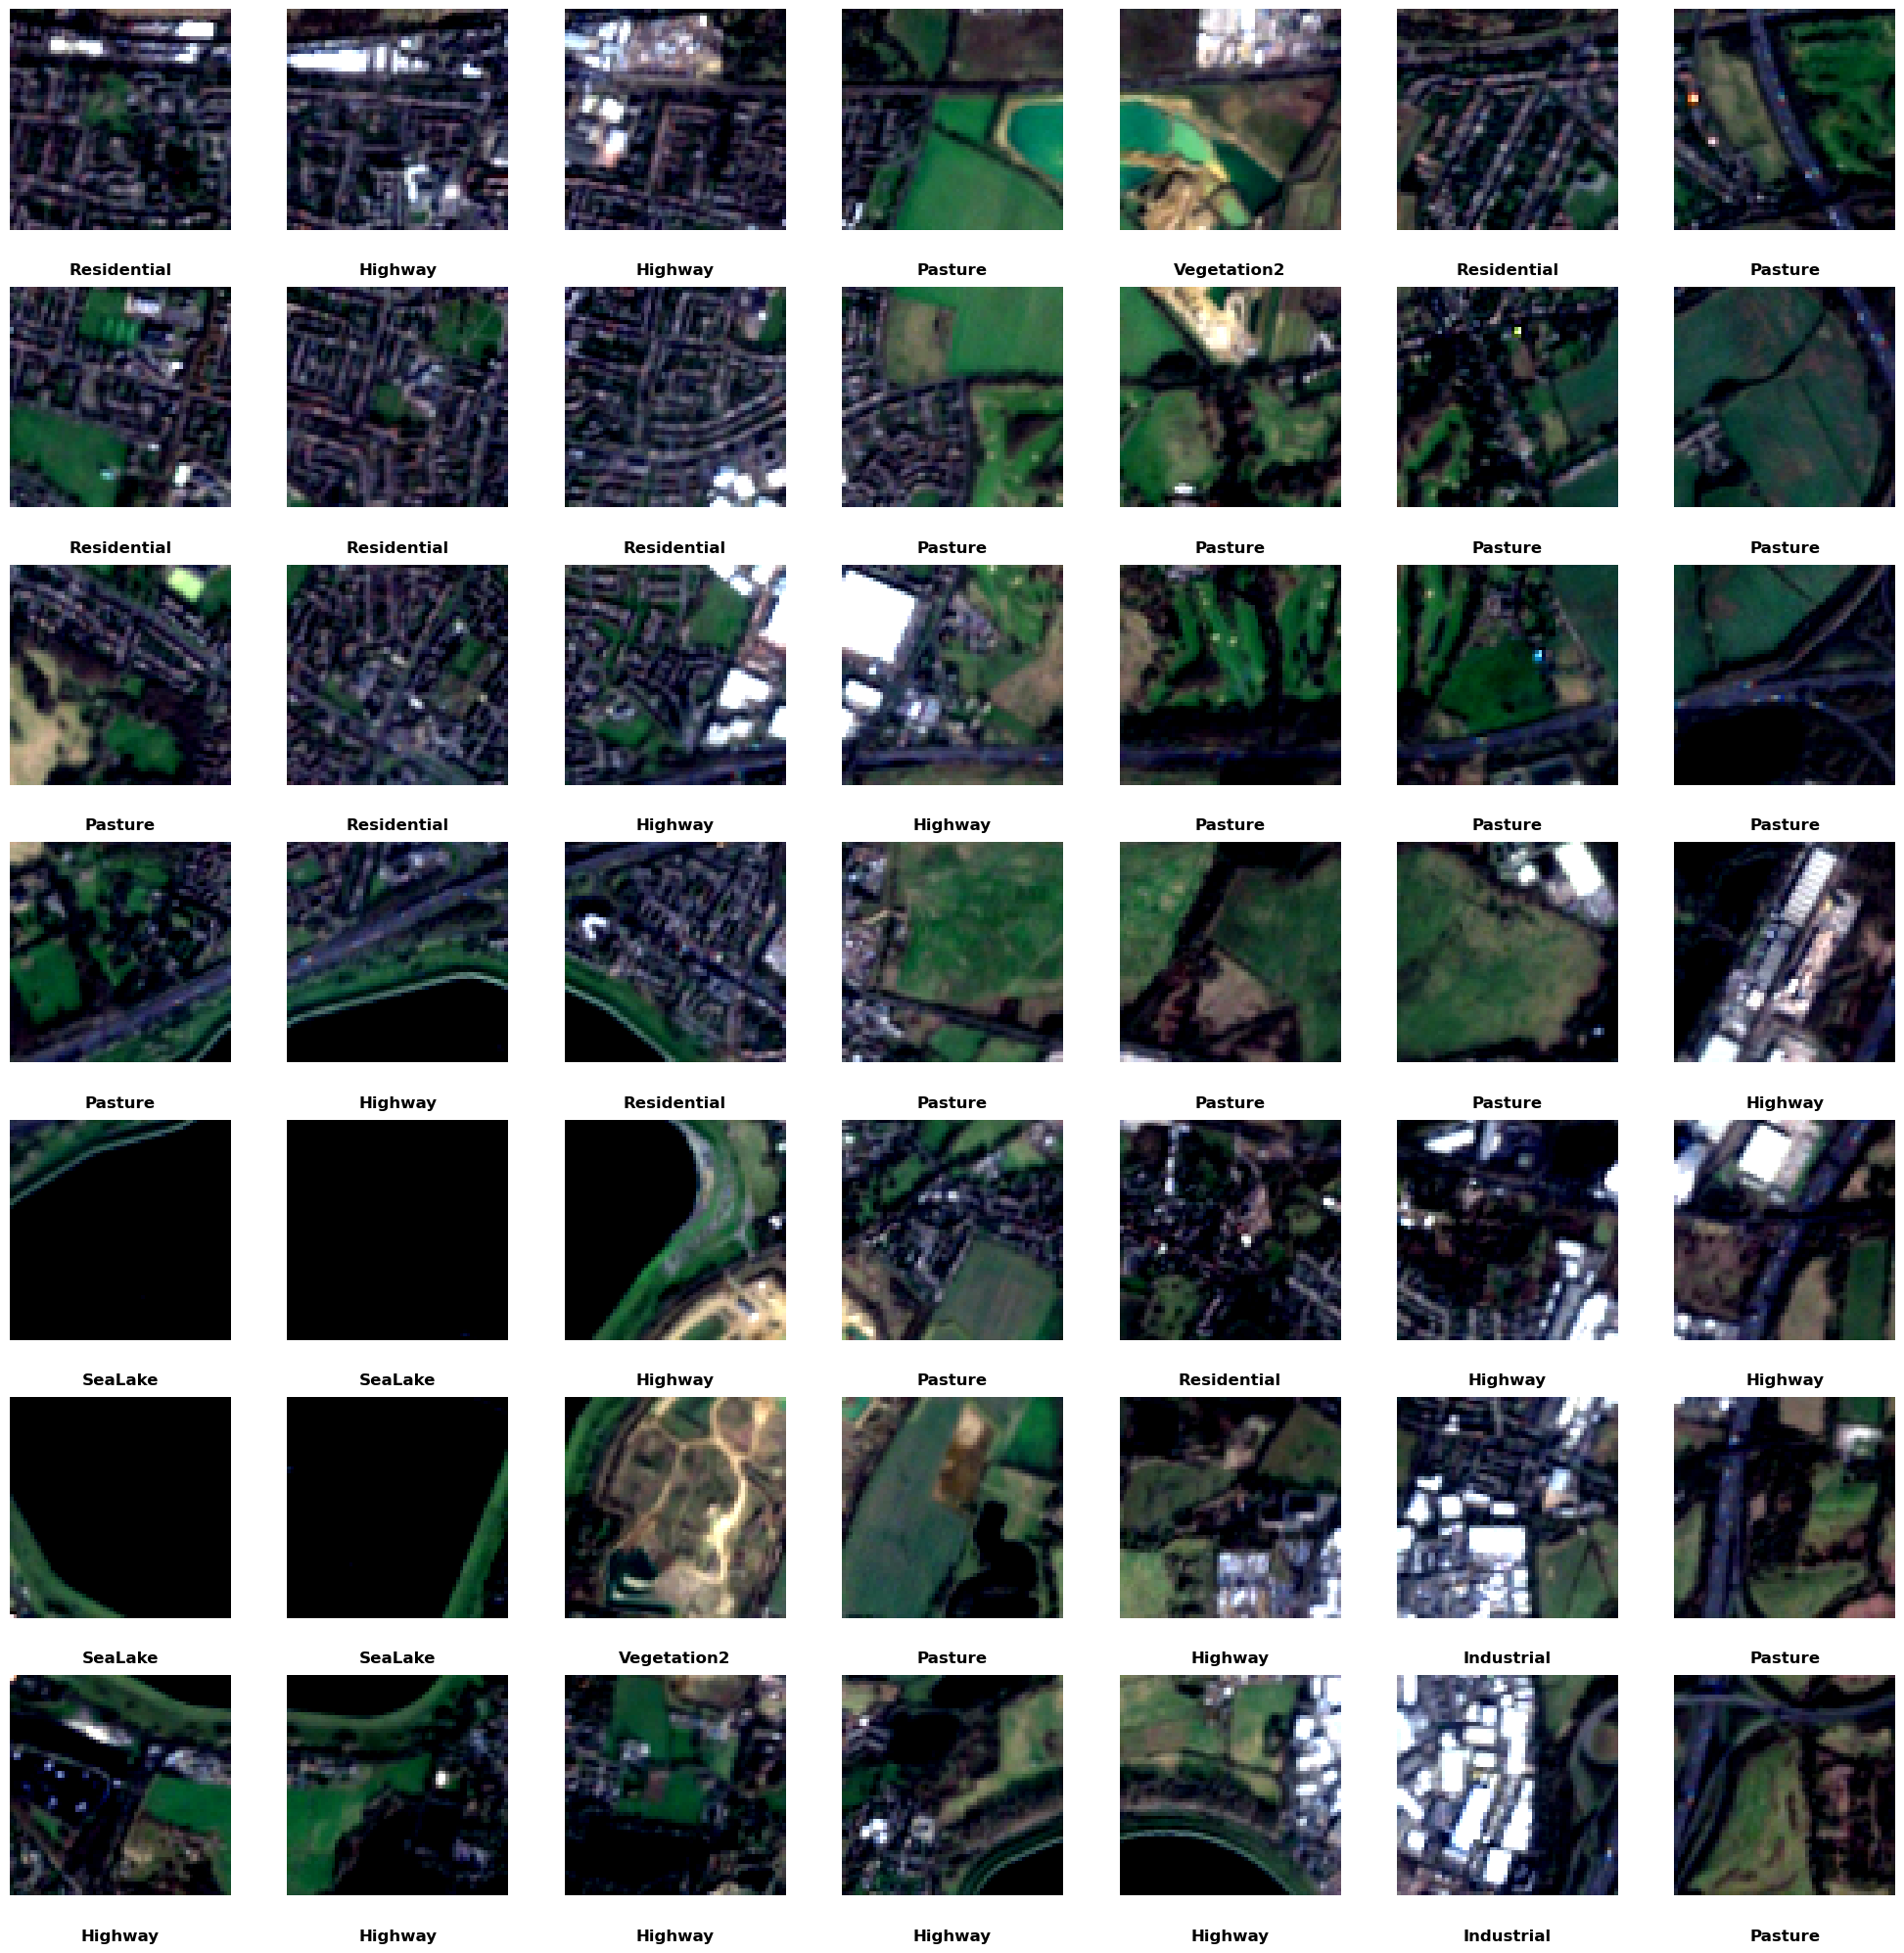

In [59]:
predict_images, predicted_classes = zip(*image_predict_zip)

# Define a colormap for different predicted classes (adjust colors as needed)
class_colors = {
    0: 'red',
    1: 'blue',
    4: 'white',
    5: 'cream',
    7: 'olive',
    8: 'green'
}

# Create a 7x7 grid
fig, axes = plt.subplots(7, 7, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    if i < len(predict_images):
        image_np = (predict_images[i] + 1) / 2  # Only if you originally normalized using mean 0, std 1
        img = image_np.cpu().numpy().transpose(1, 2, 0)

        pred_class = predicted_classes[i]

        # Display the image
        ax.imshow(img)
        ax.text(0.5, -0.15,  # Positioning the text above the image
                CLASSES_DICT[pred_class.item()], 
                ha='center', va='top',  # Center the text horizontally and align it at the top vertically
                transform=ax.transAxes,  # This makes the text position relative to the axes
                color='black', fontsize=12, fontweight='bold')

        # Remove axes
        ax.axis("off")

plt.tight_layout()
plt.show()
